19.055294036865234
9.592357635498047
1.0306761264801025
0.015861785039305687
0.009446384385228157
0.0067138164304196835


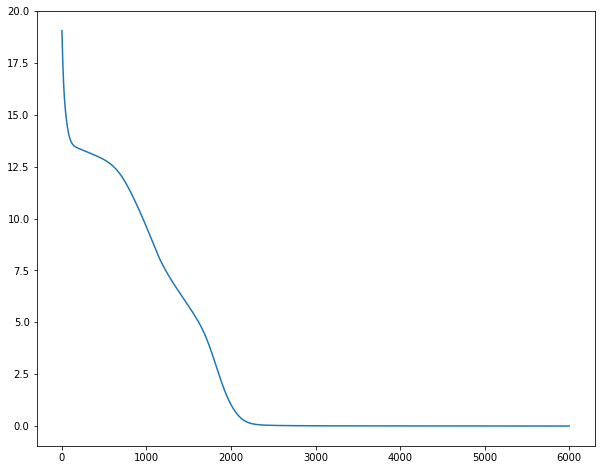

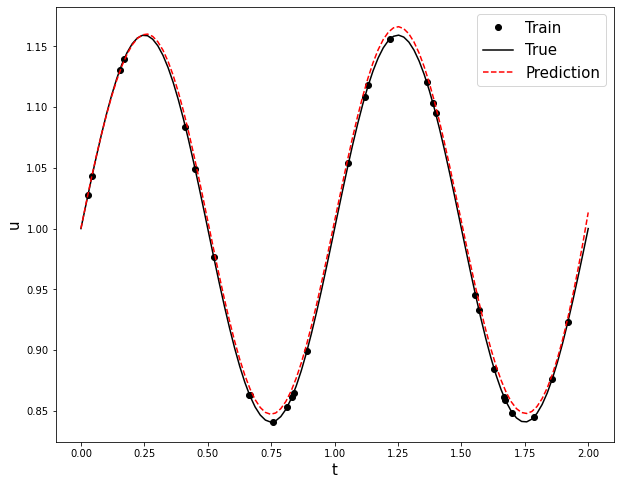

In [8]:

from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Define the model

class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.linear1 = nn.Linear(1, 32)
        self.linear2 = nn.Linear(32, 1)
        
    def forward(self, x):
        x = self.linear1(x)
        x = torch.tanh(x)
        x = self.linear2(x)
        return x

# Define the ode system and optimizer

NN = NN()

optm = optim.Adam(NN.parameters(), lr = 0.001)

def ode_system(t, net):
    t = t.reshape(-1,1)
    t = torch.from_numpy(t)
    t = Variable(t, requires_grad=True)
    t_0 = torch.zeros((1,1))
    one = torch.ones((1,1))
    
    u = net(t)
    u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0]
    
    ode_loss = u_t - torch.cos(2*np.pi*t)
    IC_loss = net(t_0) - one
    
    square_loss = torch.sum(torch.square(ode_loss)) + torch.sum(torch.square(IC_loss))
    return square_loss

train_t = (np.random.rand(30)*2).reshape(-1, 1).astype(np.float32)
train_loss_record = []

# Train the model

for itr in range(6000):
    optm.zero_grad()
    train_loss = ode_system(train_t, NN)
    train_loss_record.append(train_loss.item())
    train_loss.backward()
    optm.step()
    
    if itr % 1000 == 0:
        print(train_loss.item())

plt.figure(figsize = (10,8))
plt.plot(train_loss_record)
plt.show()
# Evaluate the model

test_t = np.linspace(0, 2, 100).reshape(-1, 1)

train_u = np.sin(2*np.pi*train_t)/(2*np.pi) + 1
true_u = np.sin(2*np.pi*test_t)/(2*np.pi) + 1
pred_u = NN(torch.from_numpy(test_t).float()).detach().numpy().ravel()

plt.figure(figsize = (10,8))
plt.plot(train_t, train_u, 'ok', label = 'Train')
plt.plot(test_t, true_u, '-k', label = 'True')
plt.plot(test_t, pred_u, '--r', label = 'Prediction')
plt.legend(fontsize = 15)
plt.xlabel('t', fontsize = 15)
plt.ylabel('u', fontsize = 15)
plt.savefig('sin2pi.pdf')  
plt.show()
